# Create Adjacency Matrices for French MP's Votes
### (14ème Législature (2012 - 2017) / DataSource: http://data.assemblee-nationale.fr/)

The French National Assembly has made available all kinds of data as part of its "Open Government" effort — among which are all recorded votes spanning the previous legislature (2012 - 2017) which can be downloaded as an XML file (JSON is also available).

XML is both very useful to efficiently store complex data, and awfully hard to navigate without a good understanding of its structure (Warning: many loops ahead!) — especially for data that changes a lot from one observation to the other. In the context of the French National Assembly, our two biggest challenges are dealing with **changes in the number and composition of Parliamentary Groups over time** (anyone familiar with the French political life over this period would know this \*cough\* *Fillon vs. Coppé...* \*cough\*... *Frondeurs...* \*cough\*... *Groupe Ecologiste)* and with **the ever-changing number of voters for each ballot**. Finally, documentation on the National Assembly's open-data website is more obscure than the financing of Sarkozy's campaign...

### Goal: create an adjacency matrix for any given ballot comparing the position of each voting MP that of her peers.

An adjacency matrix (https://en.wikipedia.org/wiki/Adjacency_matrix) is a square matrix used to represent a finite graph. The elements of the matrix indicate whether pairs of vertices are adjacent or not in the graph.

## Data Structure

Websites such as http://countwordsfree.com/xmlviewer allow you to get a grasp of the structure of your data. For our purpose, however, let us print the XML structure directly into the notebook (this will prove immensely useful later on). As you can see, the road ahead will be messy (especially as our quantity of interest lies at the very bottom of the XML.

In [1]:
import re, collections
from lxml import etree

x =  open("Scrutins_XIV.xml")
xml = x.read()

xml_root = etree.fromstring(xml)
raw_tree = etree.ElementTree(xml_root)
nice_tree = collections.OrderedDict()
 
for tag in xml_root.iter():
    path = re.sub('\[[0-9]+\]', '', raw_tree.getpath(tag))
    if path not in nice_tree:
        nice_tree[path] = []
    if len(tag.keys()) > 0:
        nice_tree[path].extend(attrib for attrib in tag.keys() if attrib not in nice_tree[path])            
 
for path, attribs in nice_tree.items():
    indent = int(path.count('/') - 1)
    print('{0}{1}: {2} [{3}]'.format('    ' * indent, indent, path.split('/')[-1], ', '.join(attribs) if len(attribs) > 0 else '-'))

0: scrutins [-]
    1: scrutin [-]
        2: uid [-]
        2: numero [-]
        2: organeRef [-]
        2: legislature [-]
        2: sessionRef [-]
        2: seanceRef [-]
        2: dateScrutin [-]
        2: quantiemeJourSeance [-]
        2: typeVote [-]
            3: codeTypeVote [-]
            3: libelleTypeVote [-]
            3: typeMajorite [-]
        2: sort [-]
            3: code [-]
            3: libelle [-]
        2: titre [-]
        2: demandeur [-]
            3: texte [-]
            3: referenceLegislative [{http://www.w3.org/2001/XMLSchema-instance}nil]
        2: objet [-]
            3: libelle [-]
            3: referenceLegislative [{http://www.w3.org/2001/XMLSchema-instance}nil]
        2: modePublicationDesVotes [-]
        2: syntheseVote [-]
            3: nombreVotants [-]
            3: suffragesExprimes [-]
            3: nbrSuffragesRequis [-]
            3: annonce [-]
            3: decompte [-]
                4: pour [-]
                4:

#  Building Adjacency Matrices

In [2]:
import xml.etree.ElementTree as ET

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

Import and read XML.

In [3]:
tree = ET.parse('/Users/Vincent/Google_Drive/AN-Project/Scrutins_XIV.xml')
root = tree.getroot()

Looking at the structure of our data (printed above), we locate our quantity of interest (the unique identifier of a MP 'PAXXX...'). For example, for the very first ballot of the legislative exercice, in the biggest political group (here, the presidential majority), among those who voted 'for', the first MP has the following unique ID:

In [4]:
root.getchildren()[0].getchildren()[-2].getchildren()[0].getchildren()[1].getchildren(
    )[0].getchildren( # which Political Group?
    )[2].getchildren( 
    )[2].getchildren(
    )[0].getchildren( # 0 : nonVotants (did not vote), 1 : pour (for), 2 : contre (against), 3 : abstention
    )[0].getchildren( # which voter / MP ?
    )[0].text # 0 : acteurRef, 1 : mandatRef, 2 : causePositionVote

'PA328'

## A quick note on challenges ahead

The challenge is, for any given ballot, to loop over all voting MPs and to extract their voting position. Populating the adjacency matrix will then be straightforward.

As mentionned before, the task is made significantly harder by the fact that the number of parliamentary groups change over time because of shifts in political alliances. 

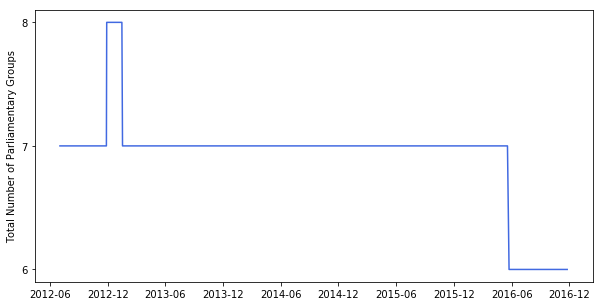

In [5]:
all_dates = [root.getchildren()[i].getchildren()[6].text for i in np.arange(len(root.getchildren()))]
all_dates = pd.to_datetime(all_dates, yearfirst = True)

number_groups = [len(root.getchildren()[i].getchildren(
                )[-2].getchildren(
                )[0].getchildren(
                )[1].getchildren()) for i in range(len(all_dates))]

plt.figure(figsize=(10, 5))
plt.plot_date(y = number_groups, x = all_dates, fmt='-', color = "royalblue");
plt.ylabel('Total Number of Parliamentary Groups');
plt.yticks(np.arange(6, 9));

Groupe du Rassemblement-UMP (R-UMP) est un ancien groupe qui avait fait scission du groupe UMP. Il est créé le **27 novembre 2012** à l'initiative de François Fillon à la suite des résultats contestés du congrès de l'UMP. Trois députés du parti radical élus avec l'étiquette de l'UMP, Jean Leonetti, Alain Marc, Frédéric Reiss, et l'unique député du Parti chrétien-démocrate (PCD), Dino Cinieri, font partie des 68 à rejoindre le groupe dès sa formation8. Le président du groupe est François Fillon. Il regroupe finalement 72 députés dont 3 apparenté. À la suite de l'accord trouvé entre François Fillon et Jean-François Copé, le groupe est dissous le **15 janvier 2013** et les députés rejoignent le groupe UMP. 

Depuis **mai 2016**, avec la disparition du groupe ÉCOLO, plusieurs députés EÉLV sont non-inscrits.

(source : Wikipedia)

The number of voters also changes (sometimes quite dramatically) from one ballot to the other. Our procedure should therefore take this fact into account.

In [6]:
len(all_dates)

1354

## The real deal

Let's start by Defining a couple of useful functions:

Throughout the process, we'll usually index all ballots by $t \in \{0, 1, ..., 1353 \}$

In [7]:
def numgroups(t):
    '''Returns the number of groups at time of ballot t'''
    return len(root.getchildren()[t].getchildren()[-2].getchildren()[0].getchildren()[1].getchildren())

def list_voters(typevote, group, t):
    '''Return an array containing the unique identifiers of all MPs voting in a specific way (*typevote*),
    in a given *group*, for a specific ballot *t*
    NB:
    typevote = {0:nonVotants, 1:pour, 2:contre, 3:abstention}'''
    
    
    voters = root.getchildren()[t].getchildren()[-2].getchildren()[0].getchildren()[1].getchildren( # Which ballot? 
        )[group].getchildren( # Which Group?
        )[2].getchildren( 
        )[2].getchildren(
        )[typevote].getchildren() # What type of vote?

    box = []
    
    if (len(voters) == 0): # No one here!
        return box
    else:
        for i in voters:
            box.append(i.getchildren()[0].text)
    return box

def print_info(t): # Interesting infos while we wait for the matrix to be created
    '''For a given ballot t, returns :
    - its name
    _ its origin (who proposed it)
    _ the date it was voted on
    _ its result '''
    titre = root.getchildren()[t].getchildren()[10].text
    typeof = root.getchildren()[t].getchildren()[8].getchildren()[1].text
    result = root.getchildren()[t].getchildren()[9].getchildren()[0].text 
    origin = root.getchildren()[t].getchildren()[11].getchildren()[0].text
    date = root.getchildren()[t].getchildren()[6].text
    print('Title: ' + titre + '\n\nProposed by: ' + origin +
          '\n\nDate: ' + date + '\n\nType of ballot: ' + typeof +
          '\n\nResult: ' + result + '\n\n')

We can now create the function that will return the Adjacency Matrix we were looking for.

It also prints out the subject of the ballot as well as whether it was passed.

In [8]:
def get_adjacency_matrix(t, as_np_array = False, verbose = True):
    """Creates and populates the adjacency matrix of all voting MPs, for ballot t
    if as_np_array = True --> returns a numpy matrix (that can be fed directly to Networkx)
    if verbose = False --> doesn't print anything"""
    
    if verbose == True:
        print_info(t) # To distract us while we wait
    
    X = numgroups(t) # How many Parliamentary groups ? (how many times do we need to loop in the XML?)
    
    # GETTING ALL INDIVIDUAL VOTE 
    #(TODO: find a more robust way to go about it)
    if (X == 6):
        a, b, c, d, e, f = [np.array(list_voters(typevote= 1, group= i, t = t)) for i in range(X)]
        pour = np.concatenate((a, b, c, d, e, f))
        a, b, c, d, e, f = [np.array(list_voters(typevote= 2, group= i, t = t)) for i in range(X)]
        contre = np.concatenate((a, b, c, d, e, f))
        a, b, c, d, e, f = [np.array(list_voters(typevote= 3, group= i, t = t)) for i in range(X)]
        abst = np.concatenate((a, b, c, d, e, f))
        a, b, c, d, e, f = [np.array(list_voters(typevote= 0, group= i, t = t)) for i in range(X)]
        no_vote = np.concatenate((a, b, c, d, e, f))
        
    elif (X == 7):
        a, b, c, d, e, f, g = [np.array(list_voters(typevote= 1, group= i, t = t)) for i in range(X)]
        pour = np.concatenate((a, b, c, d, e, f, g))
        a, b, c, d, e, f, g = [np.array(list_voters(typevote= 2, group= i, t = t)) for i in range(X)]
        contre = np.concatenate((a, b, c, d, e, f, g))
        a, b, c, d, e, f, g = [np.array(list_voters(typevote= 3, group= i, t = t)) for i in range(X)]
        abst = np.concatenate((a, b, c, d, e, f, g))
        a, b, c, d, e, f, g = [np.array(list_voters(typevote= 0, group= i, t = t)) for i in range(X)]
        no_vote = np.concatenate((a, b, c, d, e, f, g))
            
    elif (X == 8):
        a, b, c, d, e, f, g, h = [np.array(list_voters(typevote= 1, group= i, t = t)) for i in range(X)]
        pour = np.concatenate((a, b, c, d, e, f, g, h))
        a, b, c, d, e, f, g, h = [np.array(list_voters(typevote= 2, group= i, t = t)) for i in range(X)]
        contre = np.concatenate((a, b, c, d, e, f, g, h))
        a, b, c, d, e, f, g, h = [np.array(list_voters(typevote= 3, group= i, t = t)) for i in range(X)]
        abst = np.concatenate((a, b, c, d, e, f, g, h))
        a, b, c, d, e, f, g, h = [np.array(list_voters(typevote= 0, group= i, t = t)) for i in range(X)]
        no_vote = np.concatenate((a, b, c, d, e, f, g, h))
    
    # Get all voters
    allvoters = np.concatenate((pour, contre, abst, no_vote))
    
    if verbose == True:
        print('Total number of parliamentary groups : %i' %X)
        print('Total number of voters : %i' %len(allvoters))
    
    # Create Target Adjacency Matrix
    M = pd.DataFrame()
    for i in allvoters:
        M[i] = [0] * len(allvoters)

    ind = dict(zip(range(len(allvoters)), allvoters))
    M.rename_axis(ind, axis = 0, inplace=True)
    
    # Populate Adjacency Matrix
    # 1 if same vote for, against, or abstention
    # 0 if not same vote OR IF NO VOTE ! 
    
    
    for i in allvoters:
        for j in allvoters:

            if ((i in pour)&(j in pour)):
                M[i][j] = 1

            elif ((i in contre)&(j in contre)):
                M[i][j] = 1
 
            elif ((i in abst)&(j in abst)):
                M[i][j] = 1
    
    np.fill_diagonal(M.values, 0) # Set diagonal values equal to zero.
    
    print('\n\nDone!')
    
    if as_np_array == True:
        return M.values
    else:
        return M

### Examples

In [9]:
get_adjacency_matrix(867)

Title: l'ensemble du projet de loi de financement rectificative de la sécurité sociale pour 2014 (première lecture).

Proposed by: Conférence des présidents

Date: 2014-07-08

Type of ballot: scrutin public solennel

Result: adopté


Total number of parliamentary groups : 7
Total number of voters : 562


Populating...


,PA328,PA356,PA394,PA543,PA719,PA765,PA810,PA840,PA606040,PA1116,...,PA610427,PA606910,PA605922,PA1809,PA605084,PA610733,PA610521,PA610654,PA381,PA337633
PA328,0,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PA356,1,0,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PA394,1,1,0,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PA543,1,1,1,0,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PA719,1,1,1,1,0,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PA765,1,1,1,1,1,0,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PA810,1,1,1,1,1,1,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
PA840,1,1,1,1,1,1,1,0,1,1,...,0,0,0,0,0,0,0,0,0,0
PA606040,1,1,1,1,1,1,1,1,0,1,...,0,0,0,0,0,0,0,0,0,0
PA1116,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0


In [10]:
get_adjacency_matrix(57, as_np_array= True, verbose = False)

array([[0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0]])

A somewhat funny one to end with:

In [11]:
get_adjacency_matrix(1253).head()

Title: l'amendement n° 826 de Mme Abeille à l'article 27 A du projet de loi pour la reconquête de la biodiversité, de la nature et des paysages (deuxième lecture).

Proposed by: Président du groupe Les Républicains

Date: 2016-03-17

Type of ballot: scrutin public ordinaire

Result: rejeté


Total number of parliamentary groups : 7
Total number of voters : 36


Populating...


,PA2374,PA337504,PA605703,PA341246,PA607369,PA610758,PA1809,PA610427,PA810,PA695,...,PA266776,PA422119,PA608016,PA267785,PA607489,PA333421,PA332747,PA605518,PA381,PA609016
PA2374,0,1,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
PA337504,1,0,1,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
PA605703,1,1,0,1,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
PA341246,1,1,1,0,1,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
PA607369,1,1,1,1,0,1,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0


That's it ! These matrices can now be fed into ``networkx`` to create a graph.

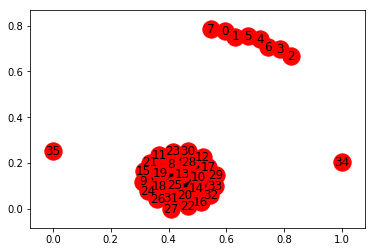

In [12]:
import networkx as nx
ballot = get_adjacency_matrix(1253, as_np_array=True, verbose = False)
ballot = nx.from_numpy_matrix(ballot)
nx.draw_networkx(ballot)

8 people voted for the proposition, 2 people did not vote, the rest voted against.

Happy analysis !

*Vincent Viers, April 2018*